In [1]:
import tensorflow as tf
import numpy as np
import emnist
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from IPython.display import display, Image
from PIL import Image, ImageFilter

import numpy


#subset = [0,1,2,3,4,5,6,7,8,9]
subset = [2, 3, 6, 7, 9]
mnist = emnist.read_data_sets('data/emnist', subset = subset)


/Users/nghia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting data/emnist/emnist-byclass-train-images-idx3-ubyte.gz
Numer of images:697932
Number of rows and cols: 28, 28
Extracting data/emnist/emnist-byclass-train-labels-idx1-ubyte.gz
Extracting data/emnist/emnist-byclass-test-images-idx3-ubyte.gz
Numer of images:116323
Number of rows and cols: 28, 28
Extracting data/emnist/emnist-byclass-test-labels-idx1-ubyte.gz
Validation size=5000
len(train_images)=697932
Only retain label: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Only retain label: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Only retain label: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
len(train_images) after filter=342584
len(train_labels) after filter=342584
number of examples:342584
number of examples:2451
number of examples:57918


('image shape:', (342584, 784))


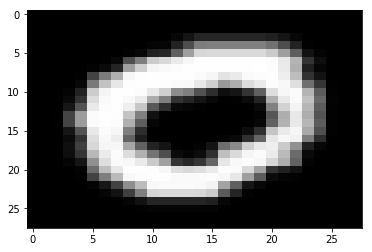

In [24]:
%matplotlib inline 
one_image = mnist.train.images[1] * 255
print("image shape:", mnist.train.images.shape)
img = Image.fromarray(one_image.reshape(28,28))
plt.imshow(img, aspect="auto")
n = 100
for i in xrange(n):
    one_image = mnist.train.images[i] * 255
    img = Image.fromarray(one_image.reshape(28,28))
    img = img.convert('RGB')
    img.save('/Users/nghiaround/Desktop/train/lot.ocrb.exp%d.png' % i)





In [2]:
def weight_variable(shape, name):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=name)

def conv2d(x, W, name=None):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name=name)

image_size = 28
num_label = len(subset)
num_steps = 20000

graph = tf.Graph()
print("mnist.train.next_batch(50):" ,mnist.train.next_batch(50)[0].shape)
with graph.as_default():  
    x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
    y_ = tf.placeholder(tf.float32, shape=[None, num_label], name='y_')
    global_step = tf.Variable(0, name='global_step', trainable=False)
       
    W_conv1 = weight_variable([5, 5, 1, 32], 'W_conv1')
    b_conv1 = bias_variable([32], 'b_conv1')
    x_image = tf.reshape(x, [-1, 28, 28, 1], name='x_image')
                        

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1, name='h_conv1')
    h_pool1 = max_pool_2x2(h_conv1, 'h_pool1')
    W_conv2 = weight_variable([5, 5, 32, 64], 'W_conv2')
    b_conv2 = bias_variable([64], 'b_conv2')
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2, 'h_pool2')
    W_fc1 = weight_variable([7 * 7 * 64, 1024], 'W_fc1')
    b_fc1 = bias_variable([1024], 'b_fc1')
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    W_fc2 = weight_variable([1024, num_label], 'W_fc2')
    b_fc2 = bias_variable([num_label], 'b_fc2')

    y_conv = tf.identity(tf.matmul(h_fc1_drop, W_fc2) + b_fc2,name='y_conv')
    tf.add_to_collection('y_conv', y_conv)
    
    
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('mnist.test_images.shape', mnist.test.images.shape)
print('mnist.test_labels.shape', mnist.test.labels.shape)

trained_filename = '/Users/nghiaround/rec_table/train/checkpoint/xx'
#print('Label ', mnist.test.labels[0:10])
with tf.Session(graph=graph) as session:
    session.run(tf.initialize_all_variables())
    saver = tf.train.Saver()
    for i in range(num_steps):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
            
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    saver.save(session, trained_filename)

('mnist.train.next_batch(50):', (50, 784))
('mnist.test_images.shape', (29368, 784))
('mnist.test_labels.shape', (29368, 5))
step 0, training accuracy 0.12
step 100, training accuracy 1
step 200, training accuracy 1
step 300, training accuracy 1
step 400, training accuracy 1
step 500, training accuracy 1
step 600, training accuracy 0.98
step 700, training accuracy 0.96
step 800, training accuracy 1
step 900, training accuracy 1
step 1000, training accuracy 1
step 1100, training accuracy 1
step 1200, training accuracy 0.94
step 1300, training accuracy 1
step 1400, training accuracy 0.98
step 1500, training accuracy 0.98
step 1600, training accuracy 1
step 1700, training accuracy 0.98
step 1800, training accuracy 0.98
step 1900, training accuracy 1
step 2000, training accuracy 1
step 2100, training accuracy 1
step 2200, training accuracy 1
step 2300, training accuracy 0.98
step 2400, training accuracy 0.98
step 2500, training accuracy 1
step 2600, training accuracy 1
step 2700, training 

In [ ]:
def imageprepare(filename):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(filename).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (0)) #creates white canvas of 28x28 pixels
    
    if width > height: #check which dimension is bigger
        #Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0/width*height),0)) #resize height according to ratio width
        if (nheight == 0): #rare case but minimum is 1 pixel
            nheight = 1
        # resize and sharpen
        img = im.resize((20,nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight)/2),0)) #caculate horizontal pozition
        newImage.paste(img, (4, wtop)) #paste resized image on white canvas
    else:
        #Height is bigger. Heigth becomes 20 pixels. 
        nwidth = int(round((20.0/height*width),0)) #resize width according to ratio height
        if (nwidth == 0): #rare case but minimum is 1 pixel
            nwidth = 1
         # resize and sharpen
        img = im.resize((nwidth,20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth)/2),0)) #caculate vertical pozition
        newImage.paste(img, (wleft, 4)) #paste resized image on white canvas
    
    #newImage.save("sample.png")

    tv = list(newImage.getdata()) #get pixel values
    
    #normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [ (x)*1.0/255.0 for x in tv] 
    return tva
    #print(tva)
    
%matplotlib inline 
image_size = 28 

graph = tf.Graph() 
with graph.as_default():
    filename = "/Users/nghiaround/Desktop/out/file229_sub_0.png"
    img = imageprepare(filename)
tt = 900
one_image = mnist.train.images[tt] 
show_image = one_image.reshape([image_size, image_size])

predict_image = np.array(img)
predict_image = predict_image.reshape([image_size, image_size])
plt.imshow(predict_image, aspect="auto") 

#show_image = numpy.flip(one_image.reshape([image_size, image_size]), 0)
#show_image = numpy.rot90(show_image, 3)
graph = tf.Graph() 

#img_input = img.reshape([1, image_size * image_size])
#img_input = one_image.reshape([1, image_size * image_size]).astype(np.float32)
letter_map = ['I', 'K', 'R', 'i', 'k', 'r']
#letter_map = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
#print("Label:", mnist.train.labels[tt])
#print("Label:", letter_map[np.argmax(mnist.train.labels[tt])])
#plt.imshow(show_image, aspect="auto") 
#print(show_image)


with graph.as_default():
    new_saver = tf.train.import_meta_graph(trained_filename + '.meta') 
    x = graph.get_tensor_by_name("x:0") 
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    y_conv = tf.get_collection('y_conv')[0]
    predict = tf.argmax(y_conv, 1)
with tf.Session(graph=graph) as session:
    new_saver.restore(session, trained_filename)
    v_ = session.run(predict, feed_dict = {"x:0": [img], "keep_prob:0": 1.0}) 
    #print(v_)
print("Result:", letter_map[v_[0]])
    
    




In [4]:
trained_filename = '/Users/nghia/rec_table/train/checkpoint/test'
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(trained_filename + ".meta")
    new_saver.restore(sess, trained_filename)
    train_op = tf.get_collection('train_op')[0]
    for step in range(2):
        sess.run(train_op)


INFO:tensorflow:Restoring parameters from /Users/nghia/rec_table/train/checkpoint/test


InvalidArgumentError: You must feed a value for placeholder tensor 'y_' with dtype float and shape [?,10]
	 [[Node: y_ = Placeholder[dtype=DT_FLOAT, shape=[?,10], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'y_', defined at:
  File "/Users/nghia/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/nghia/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-1cffef4951d9>", line 3, in <module>
    new_saver = tf.train.import_meta_graph(trained_filename + ".meta")
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1810, in import_meta_graph
    **kwargs)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/meta_graph.py", line 660, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 313, in import_graph_def
    op_def=op_def)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/nghia/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'y_' with dtype float and shape [?,10]
	 [[Node: y_ = Placeholder[dtype=DT_FLOAT, shape=[?,10], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
